


# INIT PART #
This part is just for connecting to hopsworks and downloading the dependicies needed. 

For the connecting to hopsworks we use the config file from Lab1 - somewhat moderized since we only need Hopsworks and not logging into Aqin. The config file uses our .env file that holds our respective hopsworks key.





In [20]:
!pip install hopsworks==4.2.*

  Using cached hopsworks_aiomysql-0.2.1-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 665.0/665.0 kB 7.6 MB/s  0:00:00
Using cached hopsworks_aiomysql-0.2.1-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 14.1 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s  0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.41
    Uninstalling SQLAlchemy-2.0.41:
      Successfully uninstalled SQLAlchemy-2.0.41
  Attempting uninstall: hopsworks_aiomysql━━━━━━ 0/4 [sqlalchemy]
    Found existing installation: hopsworks-aiomysql 0.2.2 [sqlalchemy]
    Uninstalling hopsworks-aiomysql-0.2.2:━━ 0/4 [sqlalchemy]
      Successfully uninstalled hopsworks-aiomysql-0.2.2/4 [sqlalchemy]
  Attempting uninstall: pandas━━━━━━━━━━━━━━ 0/4 [sqlalchemy]
    Found existing installation: pandas 2.3.3 0/4 [sqlalchemy]
    Uninstalling pandas-2.3.3:0m╺━━━━━━━━━━━━━━━━━━━ 2/4 [p

In [1]:
import sys
from pathlib import Path
import os

root_dir = Path.cwd().parent   # ← one directory up
root_dir = str(root_dir)
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")


Local environment
Added the following directory to the PYTHONPATH: /Users/fredrikschultz/Desktop/ML_Scale_Project


In [2]:
import hopsworks
project = hopsworks.login()
fs = project.get_feature_store() 

2026-01-10 19:11:08,327 INFO: Initializing external client
2026-01-10 19:11:08,327 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-10 19:11:10,695 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296539


In [24]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score





# CREATING THE FEATURE VIEW #
The following part loads our three feature groups and the joins them in the feature view "stockholm_merged_fv", where total-landings will be the target label. All groups include date which will be used when joining so each column in each row correspond to the intended date. 





In [4]:
# Retrieve feature groups
flight_arlanda_fg = fs.get_feature_group(
    name='flight_data_arlanda',
    version=1,
)

weather_cal_fg = fs.get_feature_group(
    name='stockholm_weather_calendar_features',
    version=1,
)

In [5]:
flight_arlanda_fg.schema
weather_cal_fg.schema

[Feature('date', 'timestamp', None, True, False, False, None, None, 1911280),
 Feature('day_of_week', 'bigint', None, False, False, False, None, None, 1911280),
 Feature('is_weekend', 'bigint', None, False, False, False, None, None, 1911280),
 Feature('week_of_year', 'bigint', None, False, False, False, None, None, 1911280),
 Feature('month', 'bigint', None, False, False, False, None, None, 1911280),
 Feature('is_holiday', 'bigint', None, False, False, False, None, None, 1911280),
 Feature('tavg', 'double', None, False, False, False, None, None, 1911280),
 Feature('prcp', 'double', None, False, False, False, None, None, 1911280),
 Feature('snow', 'double', None, False, False, False, None, None, 1911280),
 Feature('wspd', 'double', None, False, False, False, None, None, 1911280)]

In [6]:
# Select features for training data.
selected_features_naive = (
    flight_arlanda_fg
        .select(['date','total_landings'])
        .join(weather_cal_fg.select_features(), on=['date'])
)

feature_view = fs.get_or_create_feature_view(
    name="flight_weather_cal_fv",
    version=1,
    description="Using weather and calendar data to predict flights",
    labels=["total_landings"],
    query=selected_features_naive,
)


2026-01-10 19:11:28,941 INFO: Using ['day_of_week', 'is_weekend', 'week_of_year', 'month', 'is_holiday', 'tavg', 'prcp', 'snow', 'wspd'] from feature group `stockholm_weather_calendar_features` as features for the query. To include primary key and event time use `select_all`.






# RETRIEVING THE TRAINING DATA IN "RAW" FORMAT #
In this section we use train_test_split() from Hopsworks to split the data, and then we do a sanity check with just wrighting X_train to see that the data we have retrived is correct. 





In [7]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start="2024-12-30",
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


In [8]:
X_train

,date,day_of_week,is_weekend,week_of_year,month,is_holiday,tavg,prcp,snow,wspd
0,2022-01-18 00:00:00+00:00,1.0,0.0,3.0,1.0,0.0,0.2,0.0,0.00,18.2
1,2022-01-23 00:00:00+00:00,6.0,1.0,3.0,1.0,0.0,-1.1,0.0,0.00,14.5
2,2022-01-25 00:00:00+00:00,1.0,0.0,4.0,1.0,0.0,-1.3,0.0,0.00,12.6
3,2022-02-16 00:00:00+00:00,2.0,0.0,7.0,2.0,0.0,2.1,4.4,0.35,18.9
4,2022-02-19 00:00:00+00:00,5.0,1.0,7.0,2.0,0.0,-0.4,4.9,3.29,18.4
...,...,...,...,...,...,...,...,...,...,...
2182,2021-11-19 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2183,2021-12-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2184,2021-12-19 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185,2021-12-22 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
y_train

,total_landings
0,243
1,592
2,126
3,154
4,352
...,...
2182,307
2183,202
2184,224
2185,219






# DATA CLEANING AND FEATURE ENGINEERING 
In this section we will remove NAN values, we will also insert some new features based on the raw data. Because of this we only save raw data to feature groups and we do the feature engineering of adding for example lagging values and delta values for google trends here.





In [10]:
# 3. Sanity check to see that both X_train and y_train has the same amount of rows 
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1823 entries, 0 to 2186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1823 non-null   object 
 1   day_of_week   1091 non-null   float64
 2   is_weekend    1091 non-null   float64
 3   week_of_year  1091 non-null   float64
 4   month         1091 non-null   float64
 5   is_holiday    1091 non-null   float64
 6   tavg          1091 non-null   float64
 7   prcp          1091 non-null   float64
 8   snow          1091 non-null   float64
 9   wspd          1091 non-null   float64
dtypes: float64(9), object(1)
memory usage: 156.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1823 entries, 0 to 2186
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   total_landings  1823 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB
None


In [11]:
y_train

,total_landings
0,243
1,592
2,126
3,154
4,352
...,...
2182,307
2183,202
2184,224
2185,219


In [12]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

# MODELING 

In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 52984.90379004545
R squared: -21.159761428833008


In [19]:
df = y_test
df['predicted_landings'] = y_pred

In [20]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,total_landings,predicted_landings,date
596,123,366.698425,2024-12-30 00:00:00+00:00
904,150,402.509430,2024-12-31 00:00:00+00:00
1568,213,253.581818,2025-01-01 00:00:00+00:00
1851,209,307.952789,2025-01-02 00:00:00+00:00
1569,159,180.104416,2025-01-03 00:00:00+00:00


In [21]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "flight_google_trends_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

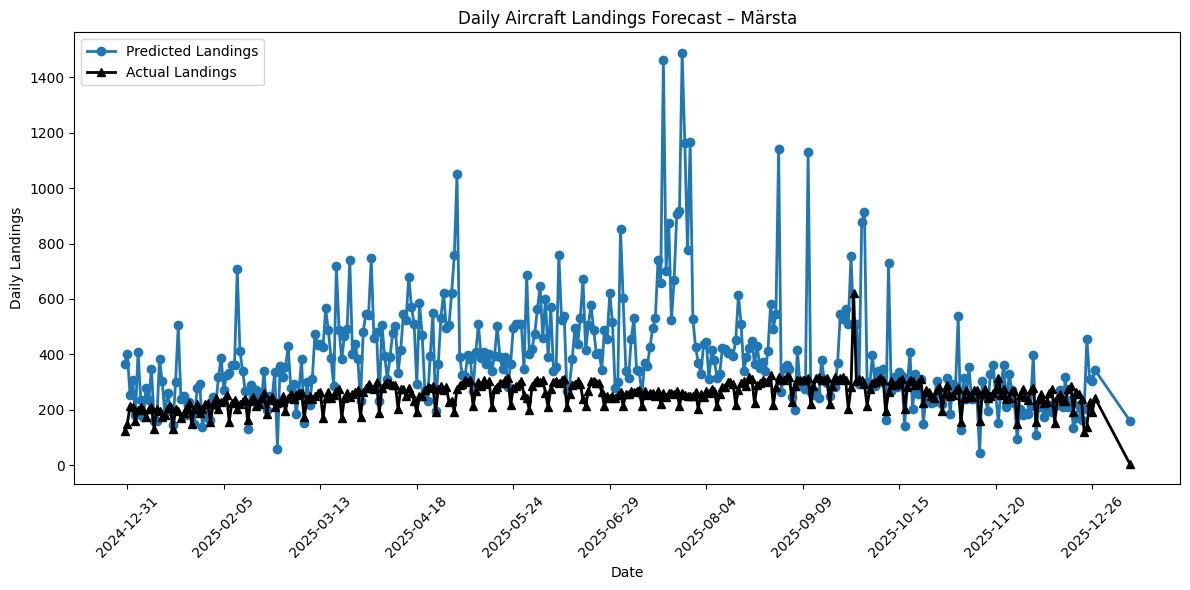

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import pandas as pd

def plot_landing_forecast(city: str,
                          df: pd.DataFrame,
                          file_path: str,
                          hindcast=False):

    fig, ax1 = plt.subplots(figsize=(12, 6))

    day = pd.to_datetime(df['date'])

    # ---- Main axis: landings ----
    ax1.plot(day, df['predicted_landings'],
             label='Predicted Landings',
             color='tab:blue', linewidth=2, marker='o')

    if hindcast:
        ax1.plot(day, df['total_landings'],
                 label='Actual Landings',
                 color='black', linewidth=2, marker='^')

    ax1.set_ylabel('Daily Landings')
    ax1.set_xlabel('Date')
    ax1.set_title(f"Daily Aircraft Landings Forecast – {city}")
    ax1.legend(loc='upper left')

    # ---- X-axis density control ----
    if len(df) > 12:
        ax1.xaxis.set_major_locator(MultipleLocator(len(df) // 10))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    return plt
    
plot_landing_forecast("Märsta", df, "flight_google_trends_model/images", hindcast=True) 

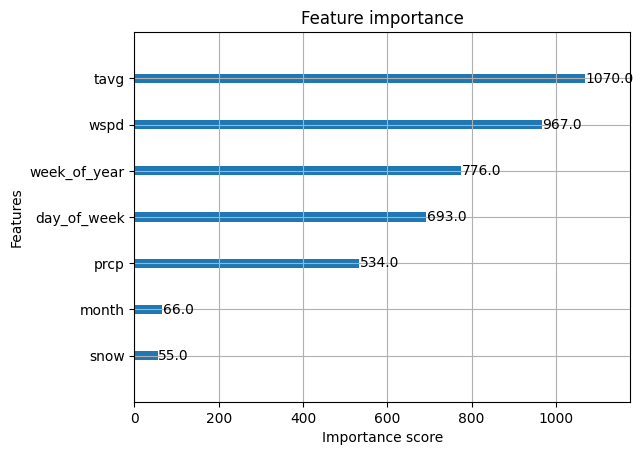

In [25]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

MODEL REGISTRY

In [26]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [27]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [28]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="flight_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Flight to Stockholm Predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/fredrikschultz/Desktop/ML_Scale_Project/pipelines/flight_google_trends_model/model.json: 0.00…

Uploading /Users/fredrikschultz/Desktop/ML_Scale_Project/pipelines/flight_google_trends_model/images.png: 0.00…

Uploading /Users/fredrikschultz/Desktop/ML_Scale_Project/pipelines/flight_google_trends_model/images/feature_i…

Uploading /Users/fredrikschultz/Desktop/ML_Scale_Project/pipelines/flight_google_trends_model/images/.ipynb_ch…

Uploading /Users/fredrikschultz/Desktop/ML_Scale_Project/pipelines/flight_google_trends_model/.ipynb_checkpoin…

Uploading /Users/fredrikschultz/Desktop/ML_Scale_Project/pipelines/model_schema.json: 0.000%|          | 0/880…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296539/models/flight_xgboost_model/1


Model(name: 'flight_xgboost_model', version: 1)